To Do:
- Add Budget constraint

# Portfolio Optimization

Adapted from: https://qiskit-community.github.io/qiskit-finance/tutorials/01_portfolio_optimization.html

We are given a set of $n$ assets $\{1, 2, ..., n\}$ each with an expected return $\mu_i$.
We assume that all assets have the same price and we have a binary choice: either choose an asset of do not.
We wish to find the maximum return:
$$ \max_{x_i} \left( \sum_i \mu_i x_i \right) = \min_{x_i} \left( - \sum_i \mu_i x_i \right)$$
where $x_i \in \{0, 1\}$ indicates a decision, 1 (0) pick (don't pick).

However we also want to take risk into account, which can be done via the covariances between the assets $\sigma_{ij}$.
Thus we want to minimize the following cost function:
$$C(\{x_i\}) = - \sum_i \mu_i x_i  + q\sum_{ij} \sigma_{ij} x_i x_j$$
where $q$ is the risk factor. 

Note that for $q=0$ we just pick the best assests based on expected return. 
For $q>0$ we take volatility into account and for $q >>0$ we pick the assets with low variance and negative covariance.
For more on the portfolio model see [here](https://en.wikipedia.org/wiki/Modern_portfolio_theory).

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

from qiskit_finance.data_providers import *
from datetime import datetime
import matplotlib.pyplot as plt

## Create the Data
We will use randomly generated data using `RandomDataProvider`.
The number of assets `num_assets` will equal the number of qubits required in the quantum computation.

In [2]:
num_assets = 4

# Generate expected return and covariance matrix from (random) time-series
stocks = [("Company %i" % i) for i in range(1, 1+num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime(2016, 1, 1),
    end=datetime(2016, 4, 30),
    seed=1,
)
data.run()

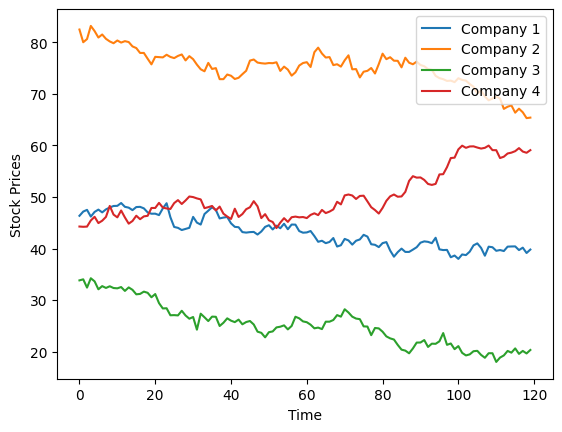

In [7]:
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.ylabel("Stock Prices")
plt.xlabel("Time")
plt.show()

## Define Terms
If $p_i^{(t)}$ is the price at time $t$ for asset $i$ then define $d_i^{(t)}$ as the return at time $t$
$$ d_i^{(t)} = \frac{p_i^{(t+1)} - p_i^{(t)}}{p_i^{(t)}} $$

To compute $\mu_i$ we calculate the mean return over the whole period and similar for the covariance:
$$ \mu_i = \frac{1}{T} \sum_t d_i^{(t)} $$
and
$$ \sigma_{ij} = \frac{1}{T-2} \sum_t (d_i^{(t)} - \mu_i ) (d_j^{(t)} - \mu_j ) $$
where $T$ is the total number of timesteps.

In [3]:
mu = data.get_period_return_mean_vector()
# print(mu)

# for i in range(num_assets):
#     x = np.array(data._data[i])
#     d = (x[1:] - x[:-1]) / x[:-1]

#     print(d.mean())

sigma = data.get_period_return_covariance_matrix()
# T = len(data._data[0])
# print(sigma)
# for i in range(num_assets):
#     for j in range(num_assets):
#         x = np.array(data._data[i])
#         y = np.array(data._data[j])

#         dx = (x[1:] - x[:-1]) / x[:-1] - mu[i]
#         dy = (y[1:] - y[:-1]) / y[:-1] - mu[j]

#         print(np.sum(dx * dy) / (T-2))

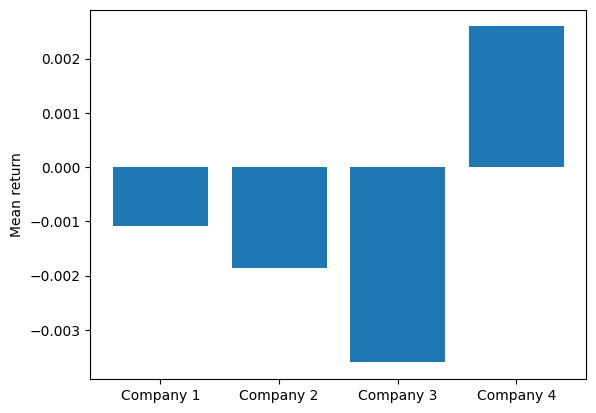

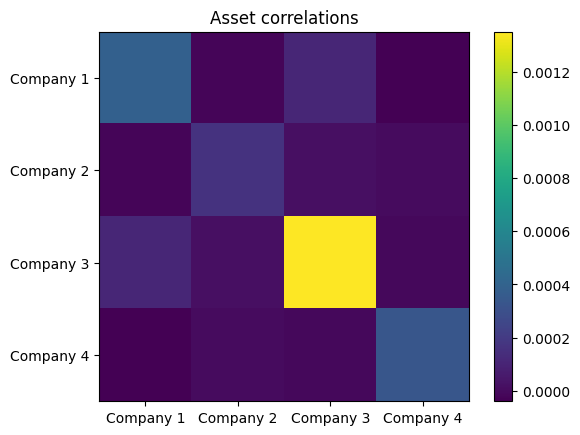

In [4]:
plt.figure()
plt.bar(range(num_assets), mu)
plt.xticks(range(num_assets), stocks)
plt.ylabel('Mean return')

plt.figure()
plt.imshow(sigma)
plt.xticks(range(num_assets), stocks)
plt.yticks(range(num_assets), stocks)
plt.title('Asset correlations')
plt.colorbar()
plt.show()

## Classial Solution

In [5]:
# Set the risk factor
q = 1.0

In [6]:
def cost_func(x):
    return - np.sum(x * mu) + q * np.sum(np.outer(x, x) * sigma)

def bin_string_to_x(bin_string):
    return np.array([int(i) for i in bin_string])

def int_to_cost(i_sol):
    x = bin_string_to_x(np.binary_repr(i_sol, num_assets))
    return cost_func(x)

In [7]:
costs = [int_to_cost(i) for i in range(2**num_assets)]

for i in range(2**num_assets):
    print(f"{np.binary_repr(i, num_assets)} ({i}), {costs[i]}")

classical_sol = np.argmin(costs)
print(f"\nBest solution: {classical_sol}, ({costs[classical_sol]})")

0000 (0), 0.0
0001 (1), -0.0022611607264786883
0010 (2), 0.004951878001374912
0011 (3), 0.0026667827704118722
0100 (4), 0.0020322131126270693
0101 (5), -0.0002287229636090388
0110 (6), 0.007018877148038771
0111 (7), 0.004734006567318312
1000 (8), 0.0014740701348145977
1001 (9), -0.0008654232200137584
1010 (10), 0.00664069304941296
1011 (11), 0.004277265190100253
1100 (12), 0.003461811994083456
1101 (13), 0.0011225432894976803
1110 (14), 0.008663220942718607
1111 (15), 0.006300017733648481

Best solution: 1, (-0.0022611607264786883)


## Quantum Solution

To Solve on a QC, we change to $x_i=(1-z_i)/2$
$$
\begin{split}
C(\{z_i\}) &= -\frac{1}{2} \sum_i \mu_i + \frac{1}{2} \sum_i \mu_i z_i + \frac{1}{4}\sum_{ij} \sigma_{ij} - \frac{1}{4}\sum_{ij} \sigma_{ij} z_j  - \frac{1}{4}\sum_{ij} \sigma_{ij} z_i + \frac{1}{4}\sum_{ij} \sigma_{ij} z_i z_j \\
&= \frac{1}{4} \sum_i (\sigma_{ii}-2\mu_i) + \frac{1}{4}\sum_{ij} \sigma_{ij} + \frac{1}{4} \sum_i \left(2 \mu_i  - \sum_{j} \sigma_{ij} - \sum_{j} \sigma_{ji} \right) z_i + \frac{1}{4}\sum_{i \ne j} \sigma_{ij} z_i z_j  \\
&= \text{const} + \frac{1}{4}\left(\sum_i  c_i z_i + \sum_{i \ne j} \sigma_{ij} z_i z_j \right) \\
\end{split}
$$
Now we have the Quantum Hamiltonian:
$$H = \sum_i  c_i Z_i + \sum_{i \ne j} \sigma_{ij} Z_i Z_j $$

Given an ansatz $|\psi(\theta)\rangle$ we minimize $\langle \psi(\theta)|H|\psi(\theta)\rangle$ to find our solution.

In [8]:
c = 2*mu - sigma.sum(0) - sigma.sum(1)
const = - 0.5 * mu.sum() + 0.25 * sigma.sum() + 0.25 * sigma.trace()

In [9]:
# Construct Hamiltonian
operators = []
coefs = []

for i in range(num_assets):
    op = ['I'] * num_assets
    op[i] = 'Z'
    operators.append(Pauli(''.join(op)))
    coefs.append(c[i])
    
for i in range(num_assets-1):
    for j in range(i+1, num_assets):
        op = ['I'] * num_assets
        op[i] = 'Z'
        op[j] = 'Z'
        operators.append(Pauli(''.join(op)))
        coefs.append(sigma[i, j] + sigma[j, i])

hamiltonian = SparsePauliOp(operators, coefs)
hamiltonian

SparsePauliOp(['ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'],
              coeffs=[-3.04008130e-03+0.j, -4.05496566e-03+0.j, -1.01293524e-02+0.j,
  4.62436394e-03+0.j, -4.44712534e-05+0.j,  2.14744913e-04+0.j,
 -7.83326283e-05+0.j,  3.47860340e-05+0.j,  2.24650243e-07+0.j,
 -2.39345045e-05+0.j])

In [10]:
hq = const + 0.25*np.diag(hamiltonian.to_matrix())
assert np.allclose(hq, costs)

In [11]:
def create_ansatz():
    qc = QuantumCircuit(num_assets)
    
    for i in range(num_assets):
        qc.ry(Parameter(f'theta_{i}'), i)
    return qc

In [12]:
ansatz = create_ansatz()
ansatz.draw()

┌─────────────┐
q_0: ┤ Ry(theta_0) ├
     ├─────────────┤
q_1: ┤ Ry(theta_1) ├
     ├─────────────┤
q_2: ┤ Ry(theta_2) ├
     ├─────────────┤
q_3: ┤ Ry(theta_3) ├
     └─────────────┘

In [13]:
estimator = StatevectorEstimator()

In [14]:
def compute_energy(params, ansatz, cost_history):
    """Return estimate of energy from estimator"""
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history.append(energy)
    print(f"Current cost: {energy}")

    return energy

In [15]:
def run_optimization(ansatz, intial_parameters):
    """Minimize the energy of a given ansatz."""

    cost_history = []
    return minimize(compute_energy, intial_parameters, method="cobyla", args=(ansatz, cost_history)), cost_history

In [16]:
res = run_optimization(ansatz, 2 * np.pi * np.random.rand(num_assets))

Current cost: -0.004630006881131615
Current cost: -0.009011754080693369
Current cost: -0.006085382556058223
Current cost: -0.006585945745322684
Current cost: -0.011652268147398434
Current cost: -0.014404911308799367
Current cost: -0.01128583084442058
Current cost: -0.017432006908333395
Current cost: -0.018877551403407907
Current cost: -0.018852529498218504
Current cost: -0.020441989243829867
Current cost: -0.014046324209967707
Current cost: -0.020300784329037036
Current cost: -0.021012760511222722
Current cost: -0.020579335785801595
Current cost: -0.020558291873699286
Current cost: -0.02053193490324532
Current cost: -0.02088797665857981
Current cost: -0.020720861949184103
Current cost: -0.021135522419994772
Current cost: -0.021320107947788127
Current cost: -0.021416808390368424
Current cost: -0.021508313935324794
Current cost: -0.02152109136268524
Current cost: -0.021527570581652233
Current cost: -0.021522818590182218
Current cost: -0.021491228469768475
Current cost: -0.021507419254127

In [17]:
def view_results(res, ansatz):
    print(res[0])
    
    sv = Statevector(ansatz.assign_parameters(res[0].x))
    probs = sv.probabilities()

    plt.bar(range(len(probs)), probs)
    plt.axvline(x=classical_sol, c='k', ls='dashed', label='Classical Sol.')
    plt.legend()
    plt.show()

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.02154166111734025
       x: [ 3.142e+00  6.283e+00 -2.600e-05  6.283e+00]
    nfev: 87
   maxcv: 0.0


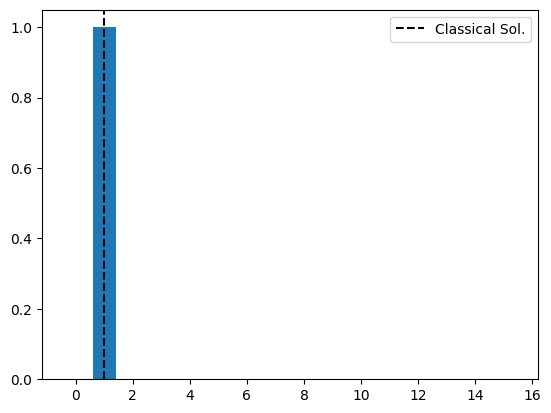

In [18]:

view_results(res, ansatz)

In [19]:
reps = 4
ansatz_qaoa = QAOAAnsatz(cost_operator=hamiltonian, reps=reps)
ansatz_qaoa.draw()

┌────────────────────────────────────────────────┐
q_0: ┤0                                               ├
     │                                                │
q_1: ┤1                                               ├
     │  QAOA(γ[0],β[0],γ[1],β[1],γ[2],β[2],γ[3],β[3]) │
q_2: ┤2                                               ├
     │                                                │
q_3: ┤3                                               ├
     └────────────────────────────────────────────────┘

In [20]:
res_qaoa = run_optimization(ansatz_qaoa, 2 * np.pi * np.random.rand(2*reps))

Current cost: 0.0022201827517404427
Current cost: 0.0015230466882162033
Current cost: 0.001184250576794669
Current cost: 0.0013112046077433358
Current cost: -0.0003198117289074015
Current cost: -3.385461081557423e-05
Current cost: -6.367347502475804e-05
Current cost: -0.0006018412628476939
Current cost: -0.0005955633850445513
Current cost: -0.0016430315128623176
Current cost: 0.0010338589845284292
Current cost: -0.0022459808490920396
Current cost: -0.0010923336781281196
Current cost: -0.003068630014132047
Current cost: -0.0022773679283996976
Current cost: -0.0027625204986562015
Current cost: -0.0036513527304289674
Current cost: -0.0005087801848753333
Current cost: -0.0037638540893724535
Current cost: -0.003473923211876059
Current cost: -0.00301594121285937
Current cost: -0.0024712014433219136
Current cost: -0.002536226311972217
Current cost: -0.0036956390403073483
Current cost: -0.003292515867570432
Current cost: -0.0036294404136513665
Current cost: -0.002995797581770307
Current cost: 

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.008773206052009682
       x: [ 9.440e+00 -1.401e-02  8.512e-03  5.499e+00  5.562e+00
            5.267e+00  9.673e+00  1.039e+01]
    nfev: 1000
   maxcv: 0.0


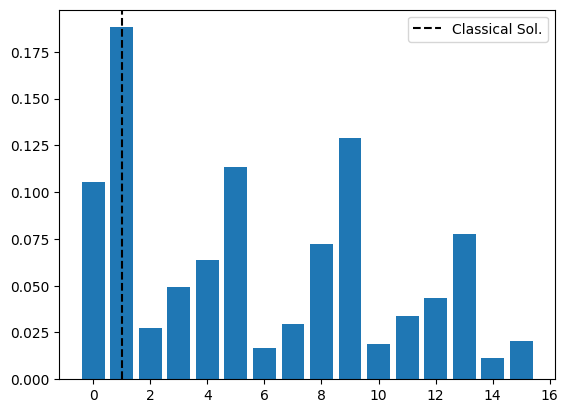

In [21]:
view_results(res_qaoa, ansatz_qaoa)